In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'

import numpy as np
np.random.seed(123456)

import sys; sys.path.append("..")
from epimodel import EpidemiologicalParameters
from epimodel.pymc3_models.mask_models import (
    RandomWalkMobilityModel,
    MandateMobilityModel
)
import epimodel.viz.mandate_wearing as mw

from epimodel.preprocessing.preprocess_mask_data import Preprocess_masks
import epimodel.viz.prior_posterior as pp

import theano.tensor as T
import theano.tensor.signal.conv as C
import theano

import pymc3 as pm
import pandas as pd
import copy
import re
import pickle
import datetime
from datetime import timedelta
import argparse
import json

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
sns.set_style("white")


import epimodel.viz.region_plot as rp
import epimodel.viz.prior_posterior as pp
import epimodel.viz.pred_cases as pc
import epimodel.viz.result_plot as rep
import epimodel.viz.mandate_wearing as mw

Set Theano Environmental Variables for Parallelisation


In [2]:
# argparser = argparse.ArgumentParser()
# argparser.add_argument('--model', dest='model', type=str, help='Model type')
# argparser.add_argument('--filter', dest='filtered', type=str, help='How to remove regions')
# argparser.add_argument('--masks', dest='masks', type=str, help='Which mask feature')
# argparser.add_argument('--w_par', dest='w_par', type=str, help='Which wearing parameterisation')
# argparser.add_argument('--mob', dest='mob', type=str, help='Which wearing parameterisation')
# args, _ = argparser.parse_known_args()

MODEL = "cases" #args.model
FILTERED = "nofilter" #args.filtered
MASKS = "wearing" #args.masks
W_PAR = "exp" # None

MOBI = 'include' # args.mob
US = True
SMOOTH = False
GATHERINGS = 3 #args.gatherings if args.gatherings else 3
# MASKING = True # Always true

TUNING = 1000
DRAWS = 700
CHAINS = 4

if MASKS == "mandate":
    n_mandates = 2
    
GRADUAL = False

In [3]:
path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
print(path)
masks_object = Preprocess_masks(path=path)

../data/modelling_set/master_data_mob_include_us_True_m_w.csv


In [4]:
# prep data object

if GRADUAL:
    path = f"../data/modelling_set/master_data_gradual_mandates{DAYS}.csv"
else:
    path = f"../data/modelling_set/master_data_mob_{MOBI}_us_{US}_m_w.csv"
print(path)
masks_object = Preprocess_masks(path=path)

../data/modelling_set/master_data_mob_include_us_True_m_w.csv
wearing
['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'avg_mobility_no_parks_no_residential', 'percent_mc']
Masking May cases in US states
centering NPIs


In [15]:
# sigma^2 = marginal variance
# std = resulting noise variance
def noise(last_noise, timescale=7, variance=0.1):
    mean = (1 - (1/timescale)) * last_noise
    variance = (2 * variance) / timescale
    std = np.sqrt(variance)
    
    return np.random.normal(mean, std)


Ds = pd.date_range("2020-05-01", "2020-09-21", freq="D")
Rs = masks_object.df.reset_index().country.unique()

def generate_noise(lt=0, scale=14, variance=0.1):
    noises = []
    for t in range(1, len(Ds)+1):
        if t % scale == 0 :
            lt = noise(lt)
        
        noises.append(lt)
    
    return np.array(noises)


def ascertainment_rate(lt):
    scaling = np.exp(lt + 1)
    return 1/scaling


def scale_cases(df, noises) :
    for r in Rs:
        rdf = df[df.country == r]
        
        for i, lt in enumerate(noises):
            scaling = np.exp(1 + lt)

            t = Ds[i].strftime("%Y-%m-%d")
            cases = rdf.loc[rdf['Date'] == t, 'ConfirmedCases']  
            rdf.loc[rdf['Date'] == t, 'ConfirmedCases'] = cases * scaling
        
        df[df.country == r] = rdf
    
    return df

daily_noises = generate_noise()
copy = masks_object.df.copy().reset_index()
masks_object.df = scale_cases(copy, daily_noises) \
                    .set_index(["country", "Date"])

if MASKS == "mandate":
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True, n_mandates=n_mandates)
if MASKS == "wearing":
    print(MASKS)
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True)#, country_leavout_inds=inds)

masks_object.make_preprocessed_object()
data = masks_object.data

print("How many regions?:", len(data.Rs))

/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


wearing
['C1_School closing', 'C1_School closing_full', 'C2_Workplace closing', 'C2_Workplace closing_full', 'C4_Restrictions on gatherings_3plus', 'C6_Stay at home requirements', 'C7_Restrictions on internal movement', 'C4_Restrictions on gatherings_2plus', 'C4_Restrictions on gatherings_full', 'avg_mobility_no_parks_no_residential', 'percent_mc']
Masking May cases in US states
centering NPIs
How many regions?: 92


In [ ]:
if MASKS == "mandate":
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True, n_mandates=n_mandates)
if MASKS == "wearing":
    print(MASKS)
    masks_object.featurize(gatherings=GATHERINGS, masks=MASKS, smooth=SMOOTH, mobility=MOBI, drop_rs=True)#, country_leavout_inds=inds)

masks_object.make_preprocessed_object()
data = masks_object.data

In [5]:
print("How many regions?:", len(data.Rs))
print("How many NPIs?:", len(data.CMs))
print("How many days?:", len(data.Ds))

#len(data.Rs)* (len(data.Ds) - 30)
data.CMs

How many regions?: 92
How many NPIs?: 11
How many days?: 144


['C1_School closing',
 'C1_School closing_full',
 'C2_Workplace closing',
 'C2_Workplace closing_full',
 'C4_Restrictions on gatherings_3plus',
 'C6_Stay at home requirements',
 'C7_Restrictions on internal movement',
 'C4_Restrictions on gatherings_2plus',
 'C4_Restrictions on gatherings_full',
 'avg_mobility_no_parks_no_residential',
 'percent_mc']

In [6]:
# model specification
ep = EpidemiologicalParameters()
bd = ep.get_model_build_dict()


def set_init_infections(data, d):
    n_masked_days = 10
    first_day_new = data.NewCases[:, n_masked_days]
    first_day_new = first_day_new[first_day_new.mask == False]
    median_init_size = np.median(first_day_new)

    if median_init_size == 0:
        median_init_size = 50

    d["log_init_mean"] = np.log(median_init_size)
    d["log_init_sd"] = np.log(median_init_size)  # TODO: wide


set_init_infections(data, bd)

bd['wearing_parameterisation'] = W_PAR


if MODEL == "cases":
    del bd["deaths_delay_mean_mean"]
    del bd["deaths_delay_mean_sd"]
    del bd["deaths_delay_disp_mean"]
    del bd["deaths_delay_disp_sd"]

    
if MASKS == "mandate":
    bd['n_mandates'] = 1
    #bd['mask_mean'] = 0.2 / bd['n_mandates']
    bd['mask_sigma'] = 0.2
    
print(bd)
print(W_PAR)

{'gi_mean_mean': 5.06, 'gi_mean_sd': 0.3265, 'gi_sd_mean': 2.11, 'gi_sd_sd': 0.5, 'cases_delay_mean_mean': 10.92830227448381, 'cases_delay_mean_sd': 0.9387435298564465, 'cases_delay_disp_mean': 5.406593726647138, 'cases_delay_disp_sd': 0.2689502951493133, 'log_init_mean': 5.457455587886334, 'log_init_sd': 5.457455587886334, 'wearing_parameterisation': 'exp'}
exp


/home/gleech/.cache/pypoetry/virtualenvs/epimodel-CmmTywaT-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [7]:
if MASKS == "wearing":
    with RandomWalkMobilityModel(data) as model:
        model.build_model(**bd)
        
elif MASKS == "mandate":
    with MandateMobilityModel(data) as model:
        model.build_model(**bd)
    

MASS = 'adapt_diag' 

with model:
    model.trace = pm.sample(
        DRAWS,
        tune=TUNING,
        cores=CHAINS,
        chains=CHAINS,
        max_treedepth=12,
        target_accept=0.9,
        init=MASS,
    )

10429
Argument: cases_delay_mean_sd not being used
Argument: cases_delay_disp_sd not being used
exp


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Psi, InitialSize_log, GI_sd, GI_mean, r_walk_noise, r_walk_noise_scale, RegionR_noise, HyperRVar, HyperRMean, Mobility_Alpha, Wearing_Alpha, CM_Alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 11021 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [11]:
trace = model.trace

In [12]:
def get_total_samples(t) :
    l = str(t).replace("<MultiTrace: ", "").split(",")
    return int(l[0].split()[0]) * int(l[1].split()[0])

get_total_samples(trace)

2000

In [13]:
import arviz as az
ess = az.ess(trace)
rhat = az.rhat(trace)


In [ ]:
varnames = trace.varnames
reds = [v for v in varnames if "reduction" in v]
vs_minus_logs = [v for v in varnames if v not in reds ]
vs = ["Psi", "InitialSize_log", "GI_sd", "GI_mean", "r_walk_noise", "r_walk_noise_scale", "RegionR_noise", "HyperRVar", "HyperRMean", "Mobility_Alpha", "Wearing_Alpha", "CM_Alpha"]

def collate(stat, varnames):
    stat_all = []
    stat_nums = []
    for var in varnames :
        if stat[str(var)].size > 1:
            stat_all.append(stat[str(var)].to_dataframe().to_numpy().flatten())
        else:
            stat_nums.append(float(stat[str(var)]))
    
    stat_all = np.concatenate(np.array(stat_all))
    stat_all = np.concatenate([stat_all, stat_nums])
    # stat_all[stat_all > 100] = 1
    return stat_all

def diagnostics(tr) :
    for r in tr.varnames :
        rhat = pm.rhat(tr)[r]
        print(f'Rhat({r}) = {rhat}')

cols = sns.cubehelix_palette(3, start=0.2, light=0.6, dark=0.1, rot=0.2)

PNAS_WIDTH_INCHES = 3.4252

def plot_sampler_stats(rhat, ess, vars_, t):
    plt.figure(figsize=(PNAS_WIDTH_INCHES * 1.5, 2), dpi=200)
    plt.subplot(121)
    plt.hist(collate(rhat, vars_), bins=40, color=cols[0])
    plt.xlabel("$\hat{R}$", fontsize=8)
    ax = plt.gca()
    ymax = ax.get_ylim()[1]
    if ymax > 1000 :
        ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax.axes.get_yticks()/1000]
        ax.set_yticklabels(ylabels)
    #ylabels = ['{:,.0f}'.format(x) for x in plt.gca().axes.get_yticks()]

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.3f'))

    plt.ylabel("# of parameters", fontsize=8)

    plt.subplot(122)
    plt.hist(collate(ess, vars_), bins=40, color=cols[0]) # / samples
    #plt.xlim() # [0,2] 
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.xlabel("ESS", fontsize=8) 
    plt.tight_layout()
    plt.suptitle(t + "\n", y=1.05)


plot_sampler_stats(rhat, ess, varnames, t="learned parameters")
plot_sampler_stats(rhat, ess, vs, t="learned parameters")
plot_sampler_stats(rhat, ess, vs_minus_logs, t="all parameters (learned + derived)")
#plot_sampler_stats(rhat, ess, ["Wearing_Alpha", "WearingReduction", "CM_Alpha"], t="wearing")

plt.savefig("../outputs/mcmc_wearing.pdf", bbox_inches="tight")


In [9]:
dt = datetime.datetime.now().strftime("%m-%d-%H:%M")
Rs = data.Rs

if MASKS == 'wearing':
    idstr = f"pickles/only_15plus_wearing_range_{MASKS}_{W_PAR}_{MODEL}_countries_{len(Rs)}_{dt}"
else:
    idstr = f"pickles/{MASKS}_2and3_{MODEL}_countries_{len(Rs)}_{dt}"

pickle.dump(model.trace, open(idstr + ".pkl", 'wb'))

with open(idstr + "_cols", "w") as f:
    f.write( ", ".join(data.CMs) )

OSError: [Errno 5] Input/output error

In [ ]:
var = ["CMReduction"]
if MASKS == "wearing" :
    var += ["WearingReduction"]
else :
    var += ["MandateReduction"]
var += ["MobilityReduction"]

#var += ["HyperRVar", "HyperRMean"]

s = pm.summary(model.trace, var_names=var, hdi_prob=0.95)
#npi_cols = data.CMs[:-2] + [data.CMs[-1]] + [data.CMs[-2]]
#s.index = npi_cols
s

In [ ]:
1 - np.median(model.trace.WearingReduction)

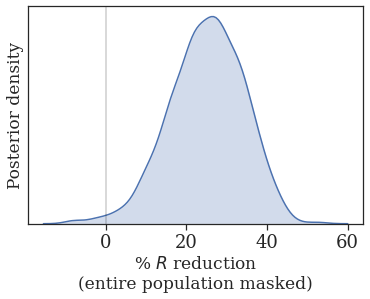

In [14]:
def main_result_posteriors(wred, ax):
    sns.kdeplot(wred, shade=True, ax=ax)
        
    ax.axvline(x=0, linestyle="-", color="black", alpha=0.2)
    ax.set_xlabel("% $R$ reduction\n(entire population masked)", fontsize=17)
    #ax.set_xlim(-20, 60)
    
    #ax.legend()
    #ax.tick_params(axis='both', which='both', labelsize=10)
    
    ax.tick_params(
    axis='y',         
    which='both',
    #length=0
    left=False
    )
    ax.yaxis.set_ticks([]) 
    
    ax.set_ylabel("Posterior density", fontsize=17)
    ax.tick_params(axis='both', which='both', labelsize=18)
    
ax = plt.gca()
main_result_posteriors((1 - trace.WearingReduction.reshape(2000,)) * 100, ax)

In [ ]:
s = pm.summary(model.trace, var_names=["HyperRVar", "HyperRMean", "r_walk_noise_scale"], hdi_prob=0.95)
#s = pm.summary(model.trace, var_names=["Wearing_HyperV"], hdi_prob=0.95)

s

In [ ]:
def main_result_posteriors(grad, old, ax, both_runs=False):
    sns.kdeplot(grad, label="7 day", color="green", shade=True, ax=ax)
    sns.kdeplot(old, label="0 day", color="blue", shade=True, ax=ax)
        
    ax.axvline(x=0, linestyle="-", color="black", alpha=0.2)
    ax.set_xlabel("% $R$ reduction", fontsize=7)
    ax.set_xlim(-20, 60)
    
    #ax.legend()
    #ax.tick_params(axis='both', which='both', labelsize=10)
    
    ax.tick_params(
    axis='y',         
    which='both',
    #length=0
    left=False
    )
    ax.yaxis.set_ticks([]) 
    
    if both_runs:
        handles, labels = ax.get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
        ax.legend(handles, labels, fontsize=7, frameon=False)
    
    ax.set_ylabel("Posterior density", fontsize=7)
    ax.tick_params(axis='both', which='both', labelsize=8)
    plt.title("Gradual mandate")

    
with open("../outputs/mandate_reduction_samples.txt", "r") as f :
    mred = f.read()
    mred = np.array(mred.split("\n")[:-1]).astype(np.float64)
    
PNAS_WIDTH_INCHES = 3.4252
fig = plt.figure(figsize=(PNAS_WIDTH_INCHES,PNAS_WIDTH_INCHES *0.5), dpi=250)
red = (1 - trace.MandateReduction.flatten()) * 100
ax = plt.gca()
main_result_posteriors(red, mred, ax)
plt.savefig(f"../outputs/gradual_posterior.pdf", bbox_inches="tight")

In [ ]:
for region in data.Rs :
    pc.epicurve_plot(data, oxcgrt, trace, region)



In [ ]:
pp.plot_all_pps(trace)